In [1]:
import sys
from pathlib import Path

# adding project root to sys.path
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from models.regressors import LinearRegressor, RidgeRegressor, LassoRegressor, XGBoostRegressor, CatBoostRegressorT, LightGBMRegressor
from models.baseline import evaluate_forecast

In [3]:
pogoh_data_22 = "../processed_data/ready/dataset_v1_pogoh_weather.csv"
pogoh_22_df = pd.read_csv(pogoh_data_22)
pogoh_22_df.head()

,date,trip_count,temp_max,temp_min,temp_mean,precip,precipitation_hours,wind_speed,wind_gusts_10m_max,wind_direction_10m_dominant,...,month_cos,dow_sin,dow_cos,trip_count_lag_1,trip_count_lag_7,trip_count_lag_14,trip_count_rolling_mean_7,trip_count_rolling_std_7,trip_count_rolling_mean_14,trip_count_rolling_std_14
0,2022-05-01,4.0,20.0,10.1,15.0,27.4,13.0,18.4,38.2,152,...,-0.866025,-0.781831,0.623490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-02,98.0,18.2,10.3,13.6,0.0,0.0,16.9,36.4,277,...,-0.866025,0.000000,1.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-03,21.0,24.3,9.3,16.1,15.6,9.0,15.8,37.8,116,...,-0.866025,0.781831,0.623490,98.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-04,44.0,17.1,12.8,15.9,1.7,8.0,18.3,39.6,287,...,-0.866025,0.974928,-0.222521,21.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-05,104.0,20.3,8.6,14.9,0.2,2.0,10.5,25.2,54,...,-0.866025,0.433884,-0.900969,44.0,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare data for modeling

In [4]:
pogoh_22_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         1280 non-null   object 
 1   trip_count                   1249 non-null   float64
 2   temp_max                     1280 non-null   float64
 3   temp_min                     1280 non-null   float64
 4   temp_mean                    1280 non-null   float64
 5   precip                       1280 non-null   float64
 6   precipitation_hours          1280 non-null   float64
 7   wind_speed                   1280 non-null   float64
 8   wind_gusts_10m_max           1280 non-null   float64
 9   wind_direction_10m_dominant  1280 non-null   int64  
 10  temp_range                   1280 non-null   float64
 11  is_rainy                     1280 non-null   int64  
 12  is_extreme_heat              1280 non-null   int64  
 13  is_extreme_cold   

In [5]:
# check for missing values
pogoh_22_df.isnull().sum()

date                            0
trip_count                     31
temp_max                        0
temp_min                        0
temp_mean                       0
precip                          0
precipitation_hours             0
wind_speed                      0
wind_gusts_10m_max              0
wind_direction_10m_dominant     0
temp_range                      0
is_rainy                        0
is_extreme_heat                 0
is_extreme_cold                 0
is_extreme_weather              0
active_closures                 0
new_closures                    0
ending_closures                 0
day_of_week                     0
month                           0
is_weekend                      0
is_holiday                      0
day_of_year                     0
week_of_year                    0
month_sin                       0
month_cos                       0
dow_sin                         0
dow_cos                         0
trip_count_lag_1               31
trip_count_lag

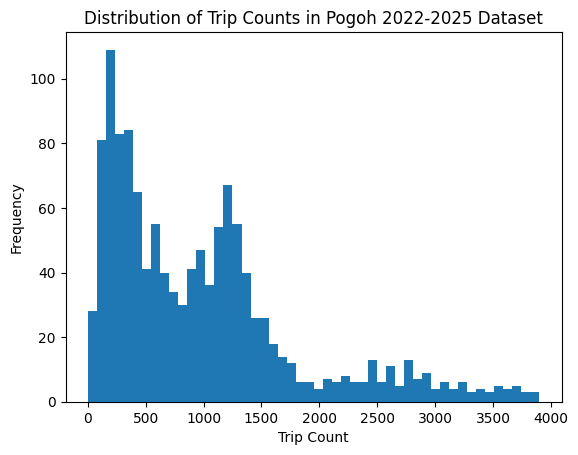

In [6]:
# trip count distribution
plt.hist(pogoh_22_df['trip_count'], bins=50)
plt.xlabel('Trip Count')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Counts in Pogoh 2022-2025 Dataset')
plt.show()

In [7]:
# fill missing values in trip_count
df_copy = pogoh_22_df.copy()
df_copy['trip_count'] = df_copy['trip_count'].fillna(method='ffill').fillna(method='bfill')


/var/folders/lr/7kcjd0991tsdqk5nrlr9gc1w0000gn/T/ipykernel_370/4158119210.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy['trip_count'] = df_copy['trip_count'].fillna(method='ffill').fillna(method='bfill')


In [8]:
df_copy.isnull().sum()

date                            0
trip_count                      0
temp_max                        0
temp_min                        0
temp_mean                       0
precip                          0
precipitation_hours             0
wind_speed                      0
wind_gusts_10m_max              0
wind_direction_10m_dominant     0
temp_range                      0
is_rainy                        0
is_extreme_heat                 0
is_extreme_cold                 0
is_extreme_weather              0
active_closures                 0
new_closures                    0
ending_closures                 0
day_of_week                     0
month                           0
is_weekend                      0
is_holiday                      0
day_of_year                     0
week_of_year                    0
month_sin                       0
month_cos                       0
dow_sin                         0
dow_cos                         0
trip_count_lag_1               31
trip_count_lag

In [9]:
# fill NaNs with the same-day trip_count
# avoiding to use a global mean and keeps the signal aligned to the current day
lag_cols = ['trip_count_lag_1', 'trip_count_lag_7', 'trip_count_lag_14']
for col in lag_cols:
    df_copy[col] = df_copy[col].fillna(df_copy['trip_count'])

df_copy[lag_cols].isnull().sum()

trip_count_lag_1     0
trip_count_lag_7     0
trip_count_lag_14    0
dtype: int64

In [10]:
# Parse dates safely
if not pd.api.types.is_datetime64_any_dtype(df_copy['date']):
    df_dates = pd.to_datetime(df_copy['date'], errors='coerce')
else:
    df_dates = df_copy['date']

ordered = df_copy.assign(__date=df_dates).sort_values('__date')

# Shift by 1 day so current day's rolling stats use only prior days
s = ordered['trip_count']
s_shift = s.shift(1)
# Compute rolling statistics
roll_mean_7 = s_shift.rolling(window=7, min_periods=1).mean()
roll_std_7 = s_shift.rolling(window=7, min_periods=1).std(ddof=0)
roll_mean_14 = s_shift.rolling(window=14, min_periods=1).mean()
roll_std_14 = s_shift.rolling(window=14, min_periods=1).std(ddof=0)

# Re-align to original row order
roll_mean_7 = roll_mean_7.sort_index()
roll_std_7 = roll_std_7.sort_index()
roll_mean_14 = roll_mean_14.sort_index()
roll_std_14 = roll_std_14.sort_index()

# OVERWRITE rolling feature columns to reflect updated trip_count
df_copy['trip_count_rolling_mean_7'] = roll_mean_7
df_copy['trip_count_rolling_std_7'] = roll_std_7
df_copy['trip_count_rolling_mean_14'] = roll_mean_14
df_copy['trip_count_rolling_std_14'] = roll_std_14

# The very first row has no prior day; set remaining NaN (if any) to 0 to avoid leakage
check_cols = [
    'trip_count_rolling_mean_7',
    'trip_count_rolling_std_7',
    'trip_count_rolling_mean_14',
    'trip_count_rolling_std_14'
]
df_copy[check_cols] = df_copy[check_cols].fillna(0)

# Sanity check: should be 0 NaNs now
df_copy[check_cols].isnull().sum()

trip_count_rolling_mean_7     0
trip_count_rolling_std_7      0
trip_count_rolling_mean_14    0
trip_count_rolling_std_14     0
dtype: int64

In [11]:
df_copy.isnull().sum()

date                           0
trip_count                     0
temp_max                       0
temp_min                       0
temp_mean                      0
precip                         0
precipitation_hours            0
wind_speed                     0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
temp_range                     0
is_rainy                       0
is_extreme_heat                0
is_extreme_cold                0
is_extreme_weather             0
active_closures                0
new_closures                   0
ending_closures                0
day_of_week                    0
month                          0
is_weekend                     0
is_holiday                     0
day_of_year                    0
week_of_year                   0
month_sin                      0
month_cos                      0
dow_sin                        0
dow_cos                        0
trip_count_lag_1               0
trip_count_lag_7               0
trip_count

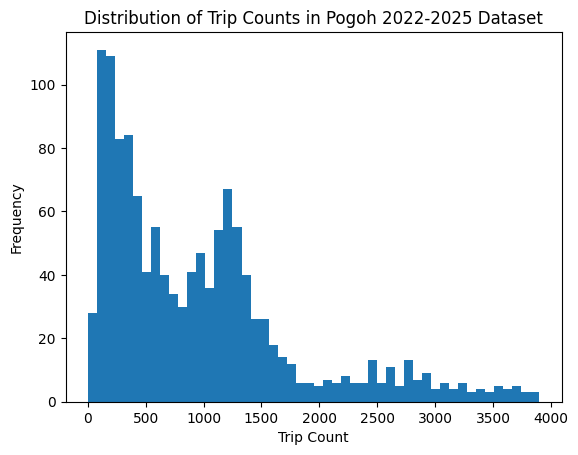

In [12]:
# trip count distribution
plt.hist(df_copy['trip_count'], bins=50)
plt.xlabel('Trip Count')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Counts in Pogoh 2022-2025 Dataset')
plt.savefig("distribution of trip.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
df_copy.head()

,date,trip_count,temp_max,temp_min,temp_mean,precip,precipitation_hours,wind_speed,wind_gusts_10m_max,wind_direction_10m_dominant,...,month_cos,dow_sin,dow_cos,trip_count_lag_1,trip_count_lag_7,trip_count_lag_14,trip_count_rolling_mean_7,trip_count_rolling_std_7,trip_count_rolling_mean_14,trip_count_rolling_std_14
0,2022-05-01,4.0,20.0,10.1,15.0,27.4,13.0,18.4,38.2,152,...,-0.866025,-0.781831,0.623490,4.0,4.0,4.0,0.00,0.000000,0.00,0.000000
1,2022-05-02,98.0,18.2,10.3,13.6,0.0,0.0,16.9,36.4,277,...,-0.866025,0.000000,1.000000,4.0,98.0,98.0,4.00,0.000000,4.00,0.000000
2,2022-05-03,21.0,24.3,9.3,16.1,15.6,9.0,15.8,37.8,116,...,-0.866025,0.781831,0.623490,98.0,21.0,21.0,51.00,47.000000,51.00,47.000000
3,2022-05-04,44.0,17.1,12.8,15.9,1.7,8.0,18.3,39.6,287,...,-0.866025,0.974928,-0.222521,21.0,44.0,44.0,41.00,40.898248,41.00,40.898248
4,2022-05-05,104.0,20.3,8.6,14.9,0.2,2.0,10.5,25.2,54,...,-0.866025,0.433884,-0.900969,44.0,104.0,104.0,41.75,35.442736,41.75,35.442736


In [14]:
# Create a copy to avoid modifying the original dataframe
df = df_copy.copy()

# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index
df.set_index('date', inplace=True)

# Fill missing values
df['trip_count'] = df['trip_count'].fillna(method='ffill').fillna(method='bfill')

# Define target and features
TARGET = 'trip_count'
FEATURES = [
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 
    'temp_mean', 'precip', 'wind_speed', 'is_holiday', 'is_weekend',
    'active_closures', 'new_closures', 'ending_closures'
]

# Ensure all feature columns are numeric
for col in FEATURES:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any remaining NaN values in features
df.dropna(subset=FEATURES, inplace=True)

y = df[TARGET]
X = df[FEATURES].copy()

/var/folders/lr/7kcjd0991tsdqk5nrlr9gc1w0000gn/T/ipykernel_370/3993103520.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['trip_count'] = df['trip_count'].fillna(method='ffill').fillna(method='bfill')


### Rolling CV with Regressors

In [15]:
# Rolling CV parameters
initial_train_size = 365
test_size = 30
step = 30

# scaling
cont_cols = ['temp_mean', 'precip', 'wind_speed', 'active_closures', 'new_closures', 'ending_closures']
scaler = StandardScaler()
X[cont_cols] = scaler.fit_transform(X[cont_cols])

# linear regressor
linear_reg = LinearRegressor(initial_train_size, test_size, step)
linear_reg.fit_predict(y, X)
linear_preds = linear_reg.get_predictions()
true_values = linear_reg.get_true_values()
linear_metrics = evaluate_forecast(true_values, linear_preds)
print("Linear Regressor Metrics:", {k: round(v, 3) for k, v in linear_metrics.items()})

# ridge regressor
ridge_reg = RidgeRegressor(initial_train_size, test_size, step, alpha=1.0)
ridge_reg.fit_predict(y, X)
ridge_preds = ridge_reg.get_predictions()
ridge_metrics = evaluate_forecast(true_values, ridge_preds)
print("Ridge Regressor Metrics:", {k: round(v, 3) for k, v in ridge_metrics.items()})

# lasso regressor
lasso_reg = LassoRegressor(initial_train_size, test_size, step, alpha=1.0)
lasso_reg.fit_predict(y, X)
lasso_preds = lasso_reg.get_predictions()
lasso_metrics = evaluate_forecast(true_values, lasso_preds)
print("Lasso Regressor Metrics:", {k: round(v, 3) for k, v in lasso_metrics.items()})

Linear Regressor Metrics: {'RMSE': np.float64(687.882), 'MAE': 522.881, 'MAPE': np.float64(52.261), 'SMAPE': np.float64(55.756)}
Ridge Regressor Metrics: {'RMSE': np.float64(686.343), 'MAE': 521.452, 'MAPE': np.float64(52.19), 'SMAPE': np.float64(55.27)}
Lasso Regressor Metrics: {'RMSE': np.float64(686.505), 'MAE': 521.443, 'MAPE': np.float64(52.175), 'SMAPE': np.float64(55.034)}


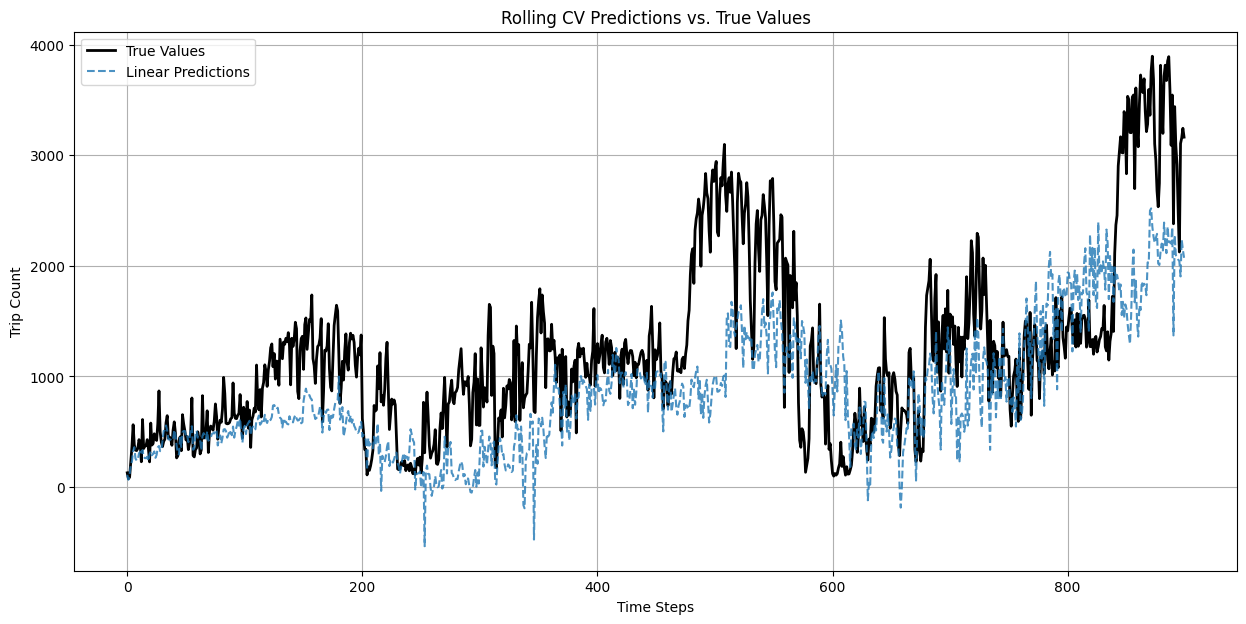

In [19]:
# Plotting the results
plt.figure(figsize=(15, 7))
plt.plot(true_values, label='True Values', color='black', linewidth=2)
plt.plot(linear_preds, label='Linear Predictions', linestyle='--', alpha=0.8)
# plt.plot(ridge_preds, label='Ridge Predictions', linestyle='-.', alpha=0.8)
# plt.plot(lasso_preds, label='Lasso Predictions', linestyle=':', alpha=0.8)
plt.title('Rolling CV Predictions vs. True Values')
plt.xlabel('Time Steps')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.savefig("linear_regressor.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# --- XGBoost Regressor with autoregressive features ---
xgb_reg = XGBoostRegressor(
    initial_train_size, 
    test_size, 
    step, 
    lags=[1, 7, 14], 
    window_features={7: ['mean', 'std'], 14: ['mean']},
    n_estimators=100
)
xgb_reg.fit_predict(y, X)
xgb_preds = xgb_reg.get_predictions()
xgb_true_values = xgb_reg.get_true_values()
xgb_metrics = evaluate_forecast(xgb_true_values, xgb_preds)
print("XGBoost Regressor Metrics:", {k: round(v, 3) for k, v in xgb_metrics.items()})

# --- CatBoost Regressor with autoregressive features ---
catboost_reg = CatBoostRegressorT(
    initial_train_size, 
    test_size, 
    step, 
    lags=[1, 7, 14], 
    window_features={7: ['mean', 'std'], 14: ['mean']},
    iterations=100
)
catboost_reg.fit_predict(y, X)
catboost_preds = catboost_reg.get_predictions()
catboost_true_values = catboost_reg.get_true_values()
catboost_metrics = evaluate_forecast(catboost_true_values, catboost_preds)
print("CatBoost Regressor Metrics:", {k: round(v, 3) for k, v in catboost_metrics.items()})

# --- LightGBM Regressor with autoregressive features ---
lgbm_reg = LightGBMRegressor(
    initial_train_size,
    test_size,
    step,
    lags=[1, 7, 14],
    window_features={7: ["mean", "std"], 14: ["mean"]},
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    verbose=-1
)
lgbm_reg.fit_predict(y, X)
lgbm_preds = lgbm_reg.get_predictions()
lgbm_true_values = lgbm_reg.get_true_values()
lgbm_metrics = evaluate_forecast(lgbm_true_values, lgbm_preds)
print("LightGBM Regressor Metrics:", {k: round(v, 3) for k, v in lgbm_metrics.items()})

XGBoost Regressor Metrics: {'RMSE': np.float64(324.111), 'MAE': 229.462, 'MAPE': np.float64(25.623), 'SMAPE': np.float64(22.826)}
CatBoost Regressor Metrics: {'RMSE': np.float64(316.838), 'MAE': 223.675, 'MAPE': np.float64(24.777), 'SMAPE': np.float64(22.346)}
LightGBM Regressor Metrics: {'RMSE': np.float64(325.486), 'MAE': 223.996, 'MAPE': np.float64(23.518), 'SMAPE': np.float64(21.767)}


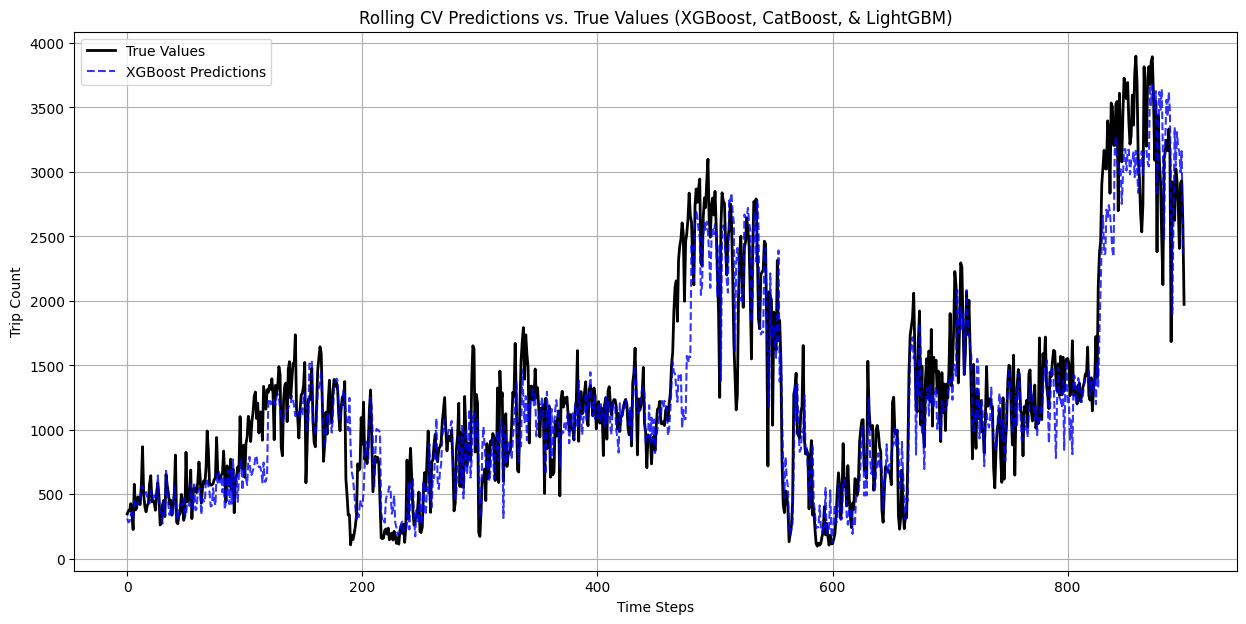

In [21]:
# Plotting the results for XGBoost, CatBoost, and LightGBM
plt.figure(figsize=(15, 7))
plt.plot(xgb_true_values, label='True Values', color='black', linewidth=2)
plt.plot(xgb_preds, label='XGBoost Predictions', linestyle='--', alpha=0.8, color='blue')
plt.title('Rolling CV Predictions vs. True Values (XGBoost, CatBoost, & LightGBM)')
plt.xlabel('Time Steps')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.savefig("xgb_regressor.png", dpi=300, bbox_inches='tight')
plt.show()

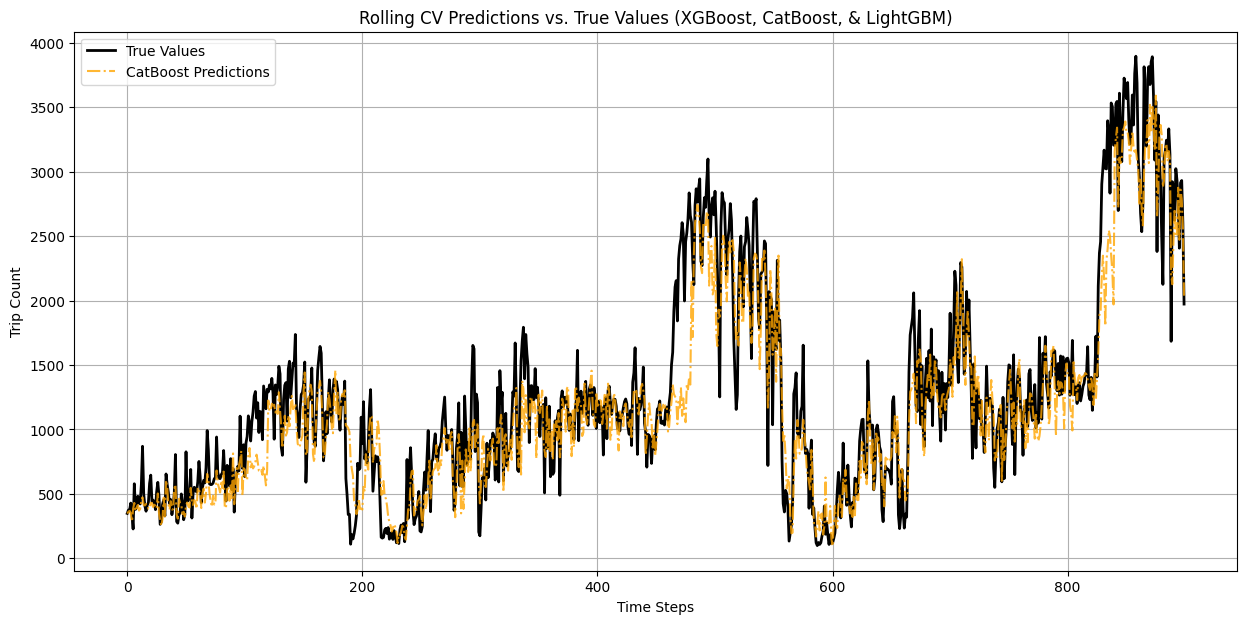

In [22]:
# Plotting the results for XGBoost, CatBoost, and LightGBM
plt.figure(figsize=(15, 7))
plt.plot(xgb_true_values, label='True Values', color='black', linewidth=2)
plt.plot(catboost_preds, label='CatBoost Predictions', linestyle='-.', alpha=0.8, color='orange')
plt.title('Rolling CV Predictions vs. True Values (XGBoost, CatBoost, & LightGBM)')
plt.xlabel('Time Steps')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.savefig("catboost_regressor.png", dpi=300, bbox_inches='tight')
plt.show()

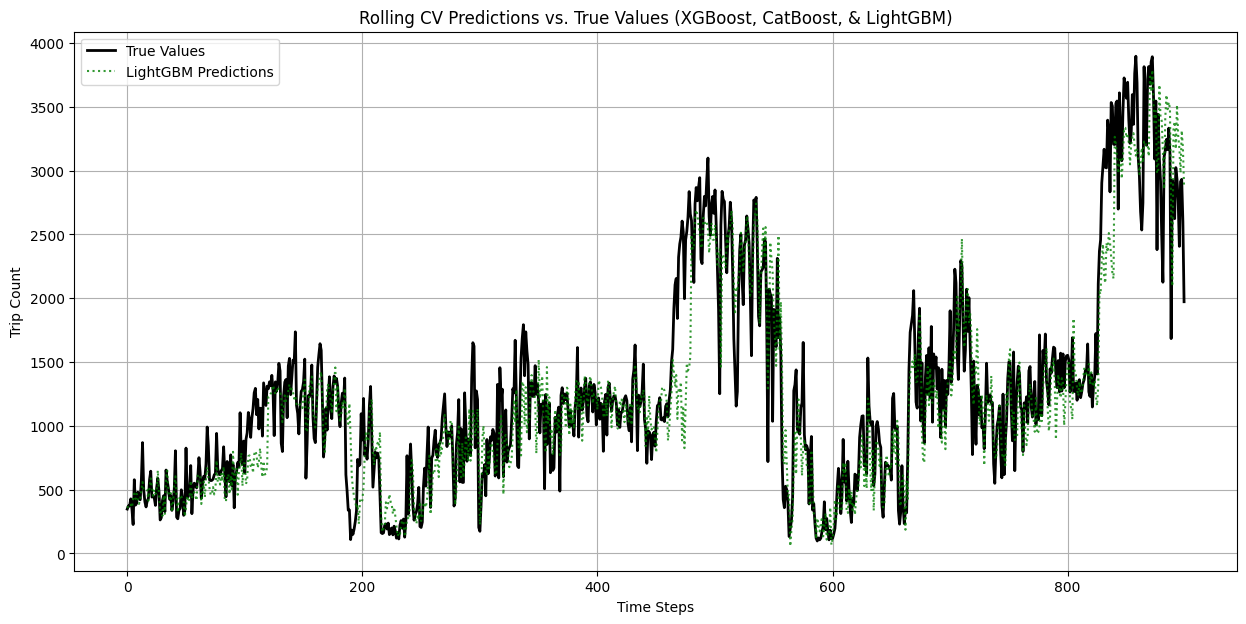

In [23]:
# Plotting the results for XGBoost, CatBoost, and LightGBM
plt.figure(figsize=(15, 7))
plt.plot(xgb_true_values, label='True Values', color='black', linewidth=2)
plt.plot(lgbm_preds, label='LightGBM Predictions', linestyle=':', alpha=0.8, color='green')
plt.title('Rolling CV Predictions vs. True Values (XGBoost, CatBoost, & LightGBM)')
plt.xlabel('Time Steps')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.savefig("lgbm_regressor.png", dpi=300, bbox_inches='tight')
plt.show()

### Anomaly Detection

In [24]:
from anomaly.detect import detect_anomalies

In [25]:
from models.rolling_cv import RollingCV

cv_results = {
    'XGBoost': (xgb_true_values, xgb_preds),
    'CatBoost': (catboost_true_values, catboost_preds),
    'LightGBM': (lgbm_true_values, lgbm_preds)
}

# The feature engineering models drop initial rows, so we need to align the dates.
# We can get the correct dates by iterating through the CV splits again.
y_feat, X_feat = xgb_reg._create_features(y, X)

cv_dates = []
cv = RollingCV(initial_train_size, test_size, step)
for _, test_indices in cv.split(y_feat):
    cv_dates.extend(y_feat.iloc[test_indices].index)
cv_dates = pd.DatetimeIndex(cv_dates)


# Store anomalies for each model
all_anomalies = {}
for model_name, (y_true, y_pred) in cv_results.items():
    anomalies = detect_anomalies(y_true, y_pred, cv_dates, threshold=2.5)
    all_anomalies[model_name] = anomalies
    print(f"{model_name}: {len(anomalies)} anomalies ({len(anomalies)/len(y_true)*100:.1f}%)")

# For individual plotting
lgbm_anomalies = all_anomalies['LightGBM']
catboost_anomalies = all_anomalies['CatBoost']
xgb_anomalies = all_anomalies['XGBoost']

XGBoost: 31 anomalies (3.4%)
CatBoost: 25 anomalies (2.8%)
LightGBM: 31 anomalies (3.4%)


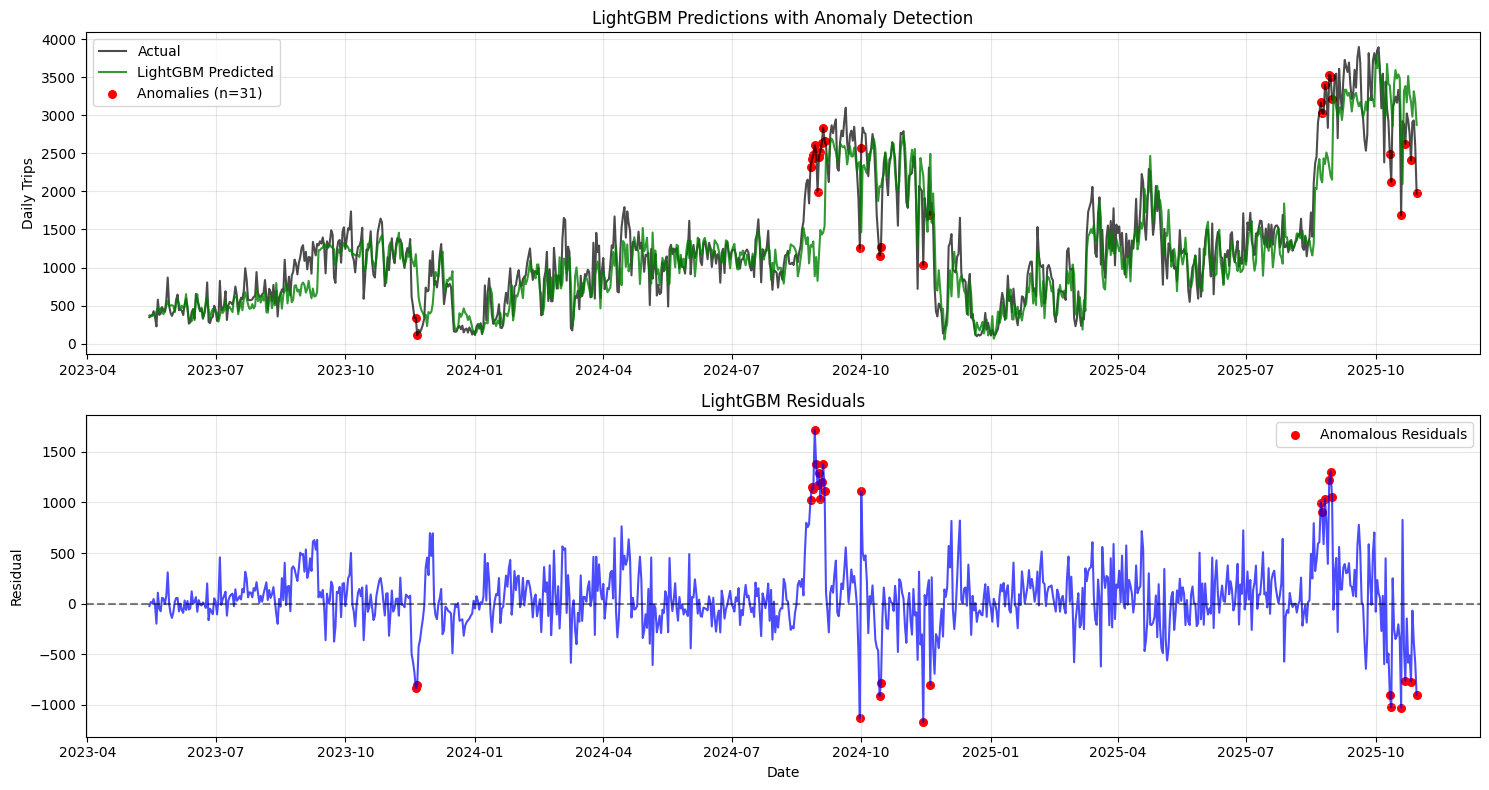

Anomaly detection complete. LightGBM detected 31 anomalies.


In [26]:
plt.figure(figsize=(15, 8))

# Plot LightGBM with anomalies
plt.subplot(2, 1, 1)
plt.plot(cv_dates, cv_results['LightGBM'][0], label='Actual', color='black', alpha=0.7)
plt.plot(cv_dates, cv_results['LightGBM'][1], label='LightGBM Predicted', color='green', alpha=0.8)
if len(lgbm_anomalies) > 0:
    plt.scatter(lgbm_anomalies.dates, lgbm_anomalies.actual_values, 
                color='red', s=30, label=f'Anomalies (n={len(lgbm_anomalies)})')
plt.title('LightGBM Predictions with Anomaly Detection')
plt.ylabel('Daily Trips')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot residuals
plt.subplot(2, 1, 2)
residuals = cv_results['LightGBM'][0] - cv_results['LightGBM'][1]
plt.plot(cv_dates, residuals, alpha=0.7, color='blue')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
if len(lgbm_anomalies) > 0:
    plt.scatter(lgbm_anomalies.dates, lgbm_anomalies.residuals, 
                color='red', s=30, label='Anomalous Residuals')
plt.title('LightGBM Residuals')
plt.ylabel('Residual')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("lgbm_anomaly_detection_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Anomaly detection complete. LightGBM detected {len(lgbm_anomalies)} anomalies.")

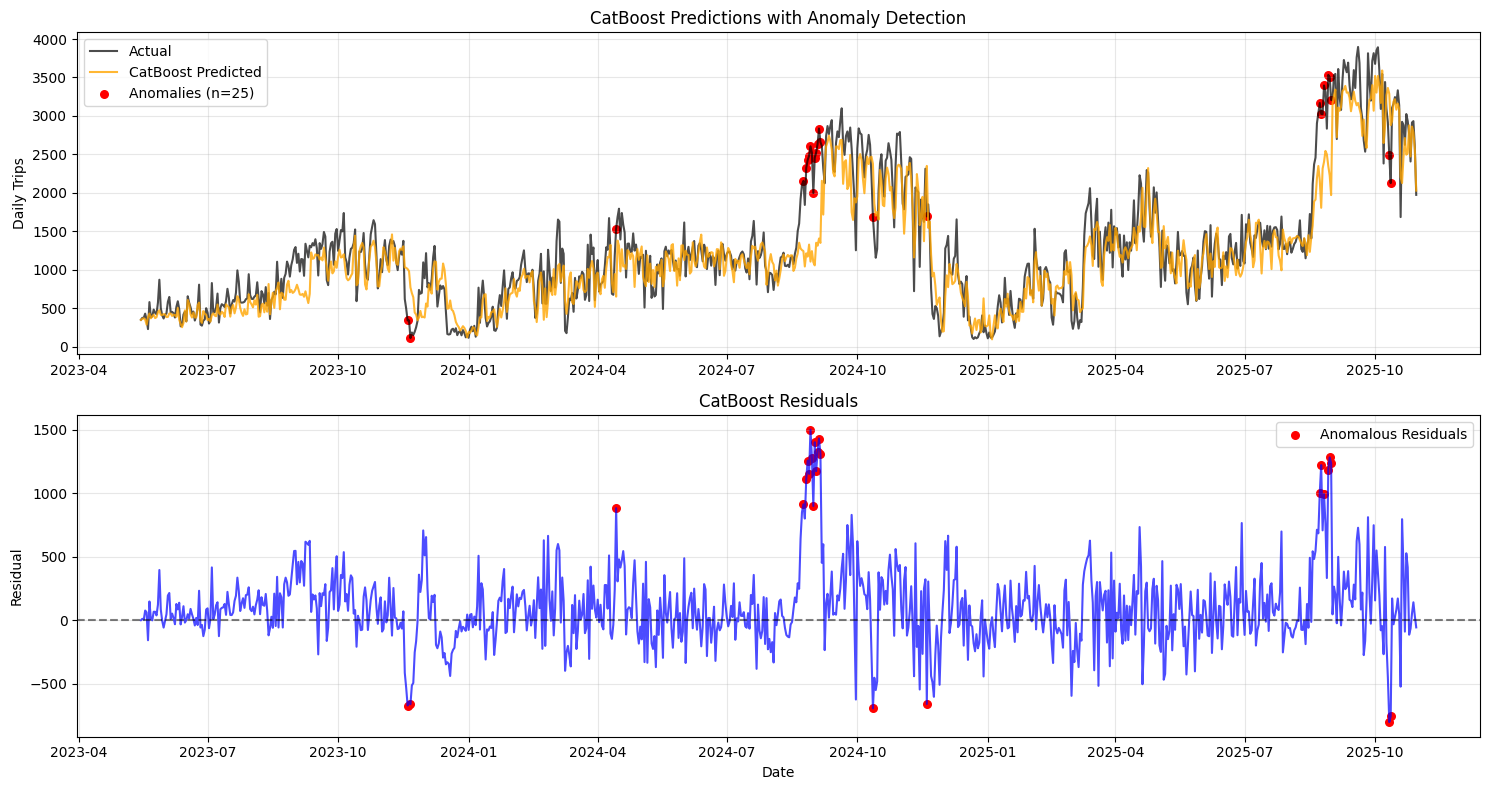

Anomaly detection complete. CatBoost detected 25 anomalies.


In [27]:
plt.figure(figsize=(15, 8))

# Plot CatBoost with anomalies
plt.subplot(2, 1, 1)
plt.plot(cv_dates, cv_results['CatBoost'][0], label='Actual', color='black', alpha=0.7)
plt.plot(cv_dates, cv_results['CatBoost'][1], label='CatBoost Predicted', color='orange', alpha=0.8)
if len(catboost_anomalies) > 0:
    plt.scatter(catboost_anomalies.dates, catboost_anomalies.actual_values, 
                color='red', s=30, label=f'Anomalies (n={len(catboost_anomalies)})')
plt.title('CatBoost Predictions with Anomaly Detection')
plt.ylabel('Daily Trips')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot residuals
plt.subplot(2, 1, 2)
residuals = cv_results['CatBoost'][0] - cv_results['CatBoost'][1]
plt.plot(cv_dates, residuals, alpha=0.7, color='blue')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
if len(catboost_anomalies) > 0:
    plt.scatter(catboost_anomalies.dates, catboost_anomalies.residuals, 
                color='red', s=30, label='Anomalous Residuals')
plt.title('CatBoost Residuals')
plt.ylabel('Residual')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("catboost_anomaly_detection_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Anomaly detection complete. CatBoost detected {len(catboost_anomalies)} anomalies.")